# Home and work detection

#### The geo location analysis tagging can be achieved through clustering. In python, clustering can be done with an array of algorithms. The most popular easily understood clustering algorithm is K-Means. This algorithm is scalable and the underlying distance metric is Euclidian distance. This works good on countries and areas near equator. However, as we move towards the poles, the algorithm performance degrades. Hence, I have used dbscan algorithm which is a density based spatial clustering algorithm. This is robust and offers a variety of distance metrics. In our case, I have used haversine distance and ball tree algorithm.The haversine formula determines the great-circle distance between two points on a sphere, given their longitudes and latitudes. Hence, it is a great choice for geo spatial clustering. Especially, when the locations point to Europe and continents away from Equator.
#### The analysis, of locations is heavily reliant on the data inconsistencies and heuristics. Knowing the coordinates can only be precise upto an extent. We find the movement patterns. We also, look at the movement timings per day, time spent in a cluster weekday vs weekend etc. I have used map visualtions through a popular library called folium. This has helped to visualise and come to conclusions.
#### Design wise, since I have accomodated two models, I have implemented Abstract factory design pattern to make the code open to extensions yet closed to modifications. There modularity is maintained throughout with object oriented design. There is no brute force algorithm in place. Most of the interactions are through optimised pandas dataframes lambda functions are used on columns of dataframes in O(n)(linear time).


In [43]:
# -*- coding: utf-8 -*-
"""
Created on Sat Aug 29 20:51:47 2020

@author: INPRB11
"""
from __future__ import annotations
from abc import ABC, abstractmethod
from datetime import tzinfo
from datetime import datetime as dt
# import pytz
from enum import Enum, auto
import copy
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from sklearn import preprocessing
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
import minisom
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import folium
from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime
from sklearn.metrics import davies_bouldin_score 
# %matplotlib notebook

# from geopy.distance import great_circle

class Dataset:
    """
    The entry point of our solution. This parses the data and exposes as a pandas dataframe
    """
    def __init__(self, filepath):
        self.data = self.parse_file(filepath)
        
    @staticmethod    
    def parse_file(filepath:str)->pd.DataFrame:
        """
        parses the geiven file based on separators
        """
        df = pd.read_csv(filepath,encoding= 'unicode_escape')
        return df
    
    def get_dataframe(self)->pd.DataFrame:
        """
        returns data as pandas dataframe
        """
        return self.data


class ClusterAbstractFactory(ABC):
    """
    The Abstract Factory interface declares a set of methods that return
    different abstract products. These products are called a family and are
    related by a high-level theme or concept. Products of one family are usually
    able to collaborate among themselves. A family of products may have several
    variants, but the products of one variant are incompatible with products of
    another.
    """
    
    def fit_model(self, df:pd.DataFrame)->None:
        """
        Interface in the abstract factory for fit_model method
        """
        pass

    
        
class ClusterConcreteFactoryKmeans(ClusterAbstractFactory):
    """
    Concrete Factories produce a family of products that belong to a single
    variant. The factory guarantees that resulting products are compatible. Note
    that signatures of the Concrete Factory's methods return an abstract
    product, while inside the method a concrete product is instantiated.
    """

    def fit_model(self, n_clusters:int, df:pd.DataFrame)->pd.DataFrame:
        """
        Implements the interface from the abstract factory
        """
        kmeans = KMeans(n_clusters = n_clusters, init ='k-means++')
        kmeans.fit(df[['latitude', 'longitude']]) # Compute k-means clustering.
        df['cluster_labels'] = kmeans.fit_predict(df[['latitude', 'longitude']])
        return ConcreteClusteringKmeans().get_clusters(df)

class ClusterConcreteFactoryDbscan(ClusterAbstractFactory):
    """
    Each Concrete Factory has a corresponding variant.
    """

    def fit_model(self, epsln:float, min_samples:int, df:pd.DataFrame)->pd.DataFrame:
        """
        Implements the interface from the abstract factory
        """
        coords = df[['latitude', 'longitude']].values
        kms_per_radian = 6371.0088
        epsilon = epsln / kms_per_radian
        db = DBSCAN(eps=epsilon, min_samples=min_samples, 
                    algorithm='ball_tree', 
                    metric='haversine').fit(np.radians(coords))
        df_copy = df.copy()
        df_copy['cluster_labels'] = db.labels_
        return ConcreteClusteringDbscan().get_clusters(df_copy)

class ClusterConcreteFactoryMinisom(ClusterAbstractFactory):
    """
    Each Concrete Factory has a corresponding variant.
    """

    def fit_model(self, map_shape:tuple, num_iterations:int, df:pd.DataFrame)->pd.DataFrame:
        """
        Implements the interface from the abstract factory
        """
        coords = df[['latitude', 'longitude']].values
        scaler = preprocessing.StandardScaler()
        coords_preprocessed = scaler.fit_transform(coords)
        mS = minisom.MiniSom(x = map_shape[0], y = map_shape[1],
                             input_len = coords.shape[1])
        mS.train_batch(coords_preprocessed, num_iteration= num_iterations,
                       verbose=False)
        #build output df
        df_copy = df.copy()
        df_copy['cluster_labels'] = np.ravel_multi_index(np.array(
            [mS.winner(x) for x in coords_preprocessed]).T, dims=map_shape)
        return ConcreteClusteringDbscan().get_clusters(df_copy)
        

class AbstractClustering(ABC):
    """
    Each distinct product of a product family should have a base interface. All
    variants of the product must implement this interface.
    """

    @abstractmethod
    def get_clusters(self) -> None:
        """
        Interface in the abstract class
        """
        pass

class ConcreteClusteringKmeans(AbstractClustering):
    """
    The variant, implements the abstract method from it's parent type
    """
    def get_clusters(self, df:pd.DataFrame) -> pd.DataFrame:
        return df


class ConcreteClusteringDbscan(AbstractClustering):
    """
    The variant, implements the abstract method from it's parent type
    """
    def get_clusters(self, df:pd.DataFrame) -> pd.DataFrame:
        return df

class ConcreteClusteringMinisom(AbstractClustering):
    """
    The variant, implements the abstract method from it's parent type
    """
    def get_clusters(self, df:pd.DataFrame) -> pd.DataFrame:
        return df
    
#client code
class ClusteredData:
    """
    The code works with factories and products only through abstract
    types: AbstractFactory and AbstractClustering. This lets you pass any factory
    or product subclass to the client code without breaking it.
    """
    class AvailableModels(Enum):
        KMEANS = auto()
        DBSCAN = auto()
        MINISOM = auto()
    factories = []
    initialized = False
    
    def __init__(self):
        if not self.initialized:
            self.initialized = True
            self.factories = []
            for d in self.AvailableModels:
                name = d.name[0] + d.name[1:].lower()
                factory_name = 'ClusterConcreteFactory'+name
                factory_instance = eval(factory_name)()
                self.factories.append((name, factory_instance))
                
    def select_model(self, df:pd.DataFrame)->pd.DataFrame:
        """
        prompts for model selection, returns the required data with cluster labels 
        """
        print('Available models:')
        for f in self.factories:
            print(f[0])
        # df = df[['latitude', 'longitude']]
        s = input(f'Please pick model (0-{len(self.factories)-1}): ')
        idx = int(s)
        if idx == 0:
            s = input(f'Specify n_clusters parameter: ')
            n_clusters = int(s)
            return self.factories[idx][1].fit_model(n_clusters, df)
        elif idx == 1:
            s = input(f'Specify epsilon parameter: ')
            epsln = float(s)
            s = input(f'Specify minimum samples parameter: ')
            min_samples = int(s)
            return self.factories[idx][1].fit_model(epsln, min_samples, df)
        elif idx == 2:
            s = input(f'Specify number of rows for map, eg. 4: ')
            map_row_shape = int(s)
            s = input(f'Specify number of columns for map, eg. 4: ')
            map_column_shape = int(s)
            s = input(f'Specify number of iterations: ')
            num_iterations = int(s)
            map_shape = (map_row_shape,map_column_shape)
            return self.factories[idx][1].fit_model(map_shape, num_iterations,
                                                    df)
        else:
            raise Exception("Please choose from the given options")
            
class DescriptiveStats:
    """
    This class lets us analyse the descriptive statistics of the person's movement
    methods: 
        1._feature_engineer(private method that extracts derived features)
        2. get_min_start_times_per_day(shows the day wise earliest start times)
        3. get_max_end_times_per_day(shows the day wise last start times)
        4. get_mean_time_spent_per_day(shows the day wise average time spent)
        5. get_max_time_spent_per_day(shows the day wise maximum time spent)
        6. get_min_time_spent_per_day(shows the day wise minimum time spent)
        7. get_unique_time_zone_per_cluster(shows the cluster wise unique timezones)
    """
    def __init__(self, clustered_data:pd.DataFrame, time_col:str):
        self.clustered_data = clustered_data
        self.time_col = time_col
        self._feature_engineer()
        self.no_clusters = len(set(self.clustered_data.loc[self.clustered_data.cluster_labels != -1]['cluster_labels'].values))
        # self.processed_data = self._feature_engineer()
        
    def _feature_engineer(self)->None:
        """
        extracts derived features like weekday, time, etc for further analysis
        """
        self.clustered_data[self.time_col] = self.\
        clustered_data[self.time_col].\
        apply(lambda x: dt.strptime(x, "%Y%m%d%H%M%z"))
        
        self.clustered_data['justdate'] = self.\
        clustered_data[self.time_col].apply(lambda x: x.date())
        
        self.clustered_data['justtime'] = self.\
        clustered_data[self.time_col].apply(lambda x: x.hour)
        
        self.clustered_data['weekday'] = self.\
        clustered_data[self.time_col].apply(lambda x: x.weekday())
        
    
    def get_min_start_times_per_day_per_cluster(self)->pd.DataFrame:
        """
        shows the day wise earliest start times
        """
        return self.clustered_data.groupby(['cluster_labels','justtime','weekday']).min()
        
    def get_max_end_times_per_day_per_cluster(self)->pd.DataFrame:
        """
        shows the day wise last start times
        """
        return self.clustered_data.groupby(['cluster_labels','justtime', 'weekday']).max()
    
    def get_mean_time_spent_per_day_per_cluster(self)->pd.DataFrame:
        """
        shows the day wise average time spent
        """
        return self.clustered_data.groupby(['cluster_labels', 'justtime', 'weekday']).mean()
    
    def get_max_time_spent_per_day_per_cluster(self)->pd.DataFrame:
        """
        shows the day wise maximum time spent
        """
        return self.clustered_data.groupby(['cluster_labels', 'justtime', 'weekday']).max()
    
    def get_min_time_spent_per_day_per_cluster(self)->pd.DataFrame:
        """
        shows the day wise minimum time spent
        """
        return self.clustered_data.groupby(['cluster_labels', 'justtime', 'weekday']).min()
    
    def get_unique_time_zone_per_cluster(self)->pd.Series:
        """
        shows the cluster wise unique timezones
        """
        self.clustered_data['timezone'] = self.clustered_data[self.time_col].\
            apply(lambda x: x.tzinfo)
        return self.clustered_data['timezone'].value_counts()
    

class Visualizer:
    """
    All the visualizations reside here
    methods: 
        1. plot_kmeans_elbow_curve(plots elbow curve for kmeans algorithm)
        2. plot_dbscan_elbow_curve(plots elbow curve for dbscan algorithm)
        3. plot_date_time_per_cluster(plots the time wise movement history per day)
        4. plot_coordinates_per_day_per_cluster(plots day wise movement history)
        5. plot_clustered_map(display clustered map. This helps in visualizing the different clusters on map)
        6. plot_movement_by_time(plots the traffic history by time on map)
        7. plot_heatmap(plot heatmap in terms of movements for a given area)
    """
    def __init__(self, clustered_data, no_clusters):
        self.clustered_data =  clustered_data
        self.no_clusters = no_clusters
        
    def plot_kmeans_elbow_curve(self)->None:
        """
        plots elbow curve for kmeans algorithm, this helps in determining the n_clusters parameter in Kmeans
        """
        distortions = []
        K = range(1,10)
        X = self.clustered_data[['latitude', 'longitude']]
        for k in K:
            kmeanModel = KMeans(n_clusters=k).fit(X)
            kmeanModel.fit(X)
            distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
        # Plot the elbow
        plt.figure()
        plt.plot(K, distortions, 'bx-', label = "distortion")
        plt.xlabel('k')
        plt.ylabel('Distortion')
        plt.xticks(rotation=70)
        plt.title('The Elbow Method showing the optimal k')
        plt.legend()
        plt.grid()
        plt.show()

    
    def plot_dbscan_elbow_curve(self)->None:
        """
        plots elbow curve for dbscan algorithm, this helps in determining the epsilon parameter in dbscan
        """
        neigh = NearestNeighbors(n_neighbors=2)
        X = self.clustered_data[['latitude', 'longitude']]
        nbrs = neigh.fit(X)
        distances, indices = nbrs.kneighbors(X)
        distances = np.sort(distances, axis=0)
        distances = distances[:,1]
        #plot the elbow
        plt.figure()
        plt.plot(distances, label="neighbour distances")
        plt.ylabel('distances')
        plt.title("Dbscan elbow curve")
        plt.xticks(rotation=70)
        plt.legend()
        plt.grid()
        plt.show()
    
    def plot_date_time_per_cluster(self)->None:
        """
        plots time wise movement history per day. This helps to understand the day-time traffic
        """
        marker_style= [".", ",", "o", "v", "^","<",">","1","2","3","4","8","s",
                       "p","P","*","h","H","+","x","X","D","d","|","_",0,1,2,
                       3,4,5,6,7,8,9,10,11]
        plt.figure(figsize=(20,10))    
        for i in range(self.no_clusters):
            color = np.array(cm.nipy_spectral(float(i) / self.no_clusters)).reshape(1,-1)
            
            if self.no_clusters <= len(marker_style):
                marker_styl= marker_style[i]
            else:
                marker_styl = "*"
            plt.scatter(self.clustered_data.
                        loc[clustered_data['cluster_labels']==i]['justdate'],
                        self.clustered_data.
                        loc[clustered_data['cluster_labels']==i]['justtime'],
                        c= color , marker = marker_styl, label = "cluster"+str(i))
        plt.xlabel("Date")
        plt.ylabel("Time(hours)")
        plt.title("Time wise movement history per day")
        plt.legend()
        plt.xticks(rotation=70)
        plt.grid()
        plt.show()
        
    def plot_coordinates_per_day_per_cluster(self)->None:
        """
        plots day wise movement history. This helps in understanding, if there's an error in the data,
        as the lat-long pair changes uniformly. A sharp change denotes anomaly like a vacation/travel or error in 
        coordinates or timezones.
        """
        # We are interested in valid clusters( in dbscan noise points are tagged as -1)
        Tot = self.no_clusters
        # Compute Rows and cols required
        Cols = 2
        Rows = Tot // Cols
        if Tot % Cols >0:
            Rows += Tot % Cols
    
    
        fig = make_subplots(rows=Rows, cols=Cols, start_cell="top-left", 
                            subplot_titles=["cluster"+str(i) for i in range(Tot)],
                           row_heights = [.8]*Rows)
        k = 0
        no_rows = Rows+1
        no_cols = Cols+1
        for r in range(1,no_rows):
            for c in range(1,no_cols):
                if Tot % 2 != 0:
                    if r== Rows and c == Cols:
                        break
                df = self.clustered_data.loc[self.clustered_data['cluster_labels']==k]
                k += 1
                fig.add_trace(go.Scatter(x = df.loc[df['weekday']>=5]['justdate'],
                                         y = df.loc[df['weekday']>=5]['latitude'],
                                         name= "latitude-"+ "weekends",
                                         mode='lines+markers'),
                              row=r, col=c)
                fig.add_trace(go.Scatter(x = df.loc[df['weekday']<5]['justdate'],
                                         y = df.loc[df['weekday']<5]['latitude'],
                                         name= "latitude-"+ "weekdays",
                                         mode='lines+markers'),
                              row=r, col=c)
                fig.add_trace(go.Scatter(x = df.loc[df['weekday']<5]['justdate'],
                                         y = df.loc[df['weekday']<5]['longitude'],
                                         name= "longitude-"+ "weekdays",
                                         mode='lines+markers'),
                              row=r, col=c)
                fig.add_trace(go.Scatter(x = df.loc[df['weekday']<5]['justdate'],
                                         y = df.loc[df['weekday']<5]['longitude'],
                                         name= "longitude-"+ "weekdays",
                                         mode='lines+markers'),
                              row=r, col=c)
                
                fig.update_xaxes(title_text="Date", row=r, col=c)
                fig.update_yaxes(title_text="Latitude-Longitude", row=r, col=c)
        fig.update_layout(title={
        'text':"Date vs Latitude-Longitude per Cluster",
        'y':0.98,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
        height=1500)
        fig.show()

        
    def plot_start_time_per_day_per_cluster(self)->None:
        """
        plots day wise start times per cluster. This helps in analyzing, the times per day for each cluster.
        """
        # We are interested in valid clusters( in dbscan noise points are tagged as -1)
        Tot = self.no_clusters
        # Compute Rows and cols required
        Cols = 2
        Rows = Tot // Cols
        if Tot % Cols >0:
            Rows += Tot % Cols
    
    
        fig = make_subplots(rows=Rows, cols=Cols, start_cell="top-left",
                           subplot_titles=["cluster"+str(i) for i in range(Tot)],
                           row_heights = [.95]*Rows)
        k = 0
        no_rows = Rows+1
        no_cols = Cols+1
        for r in range(1,no_rows):
            for c in range(1,no_cols):
                if Tot % 2 != 0:
                    if r== Rows and c == Cols:
                        break
                df = self.clustered_data.loc[self.clustered_data['cluster_labels']==k]
                fig.add_trace(go.Scatter(x = df.loc[df['weekday'] >=5]['justdate'],
                                         y = df.loc[df['weekday'] >=5]['justtime'],
                                         name= "cluster "+str(k)+" weekends",
                                         mode='markers'),
                              row=r, col=c)
                fig.add_trace(go.Scatter(x = df.loc[df['weekday'] <5]['justdate'],
                                         y = df.loc[df['weekday'] <5]['justtime'],
                                         name= "cluster "+str(k)+" weekdays",
                                         mode='markers'),
                              row=r, col=c)
                fig.update_xaxes(title_text="Date", row=r, col=c)
                fig.update_yaxes(title_text="Time(hours)", row=r, col=c)
                k += 1
        fig.update_layout(title={
        'text':"Date vs Times per Cluster",
        'y':0.98,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
        height=1000)
        fig.show()

    
    def plot_clustered_map(self, latitude:float, longitude:float, zoom:int, no_clusters:int, df:pd.DataFrame)->None:
        """
        display clustered map. This helps in visualizing the different clusters on map
        """
        map_clusters = folium.Map(location=[latitude, longitude], zoom_start= zoom)
        # set color scheme for the clusters
        x = np.arange(no_clusters)
        ys = [i + 5*x + (i*x)**2 for i in range(1)]
        colors_array = cm.gist_ncar(ys[0])
        gist_ncar = [colors.rgb2hex(i) for i in colors_array]
    
        # add markers to the map
        for lat, lng, cluster, duration, time in zip(df['latitude'], df['longitude'], df['cluster_labels'],
                                                    df['duration(ms)'],df['start_time(YYYYMMddHHmmZ)']):
            folium.vector_layers.CircleMarker(
                [lat, lng],
                radius=5,
                tooltip = str(round((duration/3600000),3))+ 'hrs , spent from '+str(time) + '- Cluster ' + str(cluster),
                color=gist_ncar[cluster-1],
                fill=True,
                fill_color=gist_ncar[cluster-1],
                fill_opacity=0.9).add_to(map_clusters)
        loc = [(df.loc[df['cluster_labels']==c]['latitude'].mean(),
                df.loc[df['cluster_labels']==c]['longitude'].mean(), c) for c in range(no_clusters)]
        for location in loc:
            folium.Marker(location[:2], popup="cluster-"+str(location[2])).add_to(map_clusters)
    
        display(map_clusters)
    

    def plot_movement_by_time(self, latitude:float, longitude:float, zoom:int, df:pd.DataFrame)->None:
        """
        plots the traffic history by time on map. Please click on the play button
        """
        df_hour_list = []
        for hour in self.clustered_data['justtime'].sort_values().unique():
            df_hour_list.append(self.clustered_data.loc
                                [self.clustered_data.justtime == hour, ['latitude', 'longitude', 'count']].
                                groupby(['latitude', 'longitude']).sum().reset_index().values.tolist())
        base_heattimemap = folium.Map(location=[latitude, longitude], zoom_start= zoom)
        HeatMapWithTime(df_hour_list, 
                        radius=8, gradient={0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'}, 
                        min_opacity=0.8, max_opacity=1, use_local_extrema=True).add_to(base_heattimemap)
    
        display(base_heattimemap)
    
    
    def plot_heatmap(self, latitude:float, longitude:float, zoom:int, df:pd.DataFrame)->None:
        """
        display heatmap in terms of movements for a given area
        """
        from folium.plugins import HeatMap
        # Add a column with ones, then calculate sum and generate the measure for heat
        self.clustered_data['count'] = 1 
        # create map of Calgary using latitude and longitude values
        base_heatmap = folium.Map(location=[latitude, longitude], zoom_start= zoom)
        # Just adding a marker for long hours spent
        loc = (self.clustered_data.loc[self.clustered_data['duration(ms)'] 
                                       == max(self.clustered_data['duration(ms)'])].values[0][0],
               self.clustered_data.loc[self.clustered_data['duration(ms)'] == 
                                       max(self.clustered_data['duration(ms)'])].values[0][1])
        folium.Marker(loc, popup="longhours spent here").add_to(base_heatmap)
        HeatMap(data=df[['latitude', 'longitude', 'count']].groupby(['latitude', 'longitude'])
                .sum().reset_index().values.tolist(), radius=8, max_zoom=4).add_to(base_heatmap)
        # To show the map in jupyter
        display(base_heatmap)

## Person1

In [45]:
#building the dataset
d = Dataset(r'person1_NYCtaxi.csv')
cd = ClusteredData()
#Modelling
clustered_data = cd.select_model(d.get_dataframe())
#getting descriptive statistics
desc = DescriptiveStats(clustered_data, 'start_time(YYYYMMddHHmmZ)')
min_start_time = desc.get_min_start_times_per_day_per_cluster()
max_end_time = desc.get_max_end_times_per_day_per_cluster()
mean_time_spent_per_cluster = desc.get_mean_time_spent_per_day_per_cluster()
min_time_spent_per_cluster = desc.get_min_time_spent_per_day_per_cluster()
max_time_spent_per_cluster = desc.get_max_time_spent_per_day_per_cluster()
unique_timezones = desc.get_unique_time_zone_per_cluster()

Available models:
Kmeans
Dbscan
Minisom
Please pick model (0-2): 1
Specify epsilon parameter: .05
Specify minimum samples parameter: 7


In [46]:
# silhoutte score
silhouette_score(desc.clustered_data[['latitude', 'longitude']], desc.clustered_data['cluster_labels'])

-0.4749873062914621

In [47]:
# db index
print(davies_bouldin_score(desc.clustered_data[['latitude', 'longitude']], desc.clustered_data['cluster_labels'])) 

1.6257365950577192


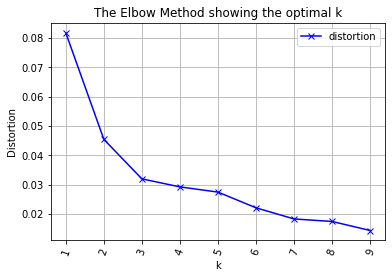

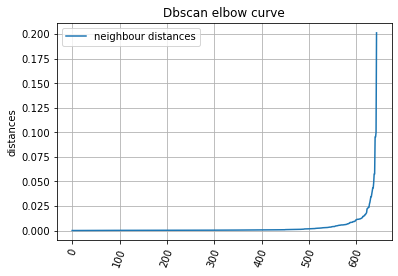

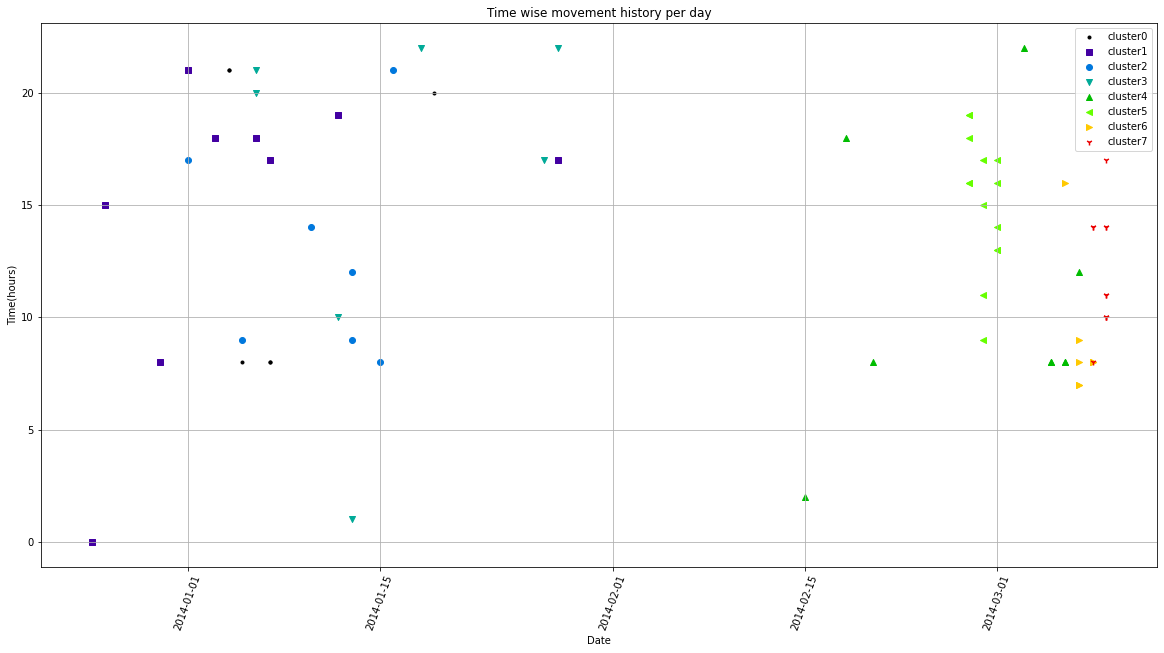

In [48]:
#generating visualizations
visuals = Visualizer(desc.clustered_data, desc.no_clusters)
visuals.plot_kmeans_elbow_curve()
visuals.plot_dbscan_elbow_curve()
visuals.plot_date_time_per_cluster()
visuals.plot_start_time_per_day_per_cluster()
visuals.plot_coordinates_per_day_per_cluster()
#setting parameters for map
latitude = desc.clustered_data['latitude'].mean()#mean of the latitude for the person's movement history
longitude = desc.clustered_data['longitude'].mean() #mean of the longitude for the person's movement history
zoom = 10
visuals.plot_heatmap(latitude, longitude, zoom, desc.clustered_data)
visuals.plot_movement_by_time(latitude, longitude, zoom, desc.clustered_data)
v=visuals.plot_clustered_map(latitude, longitude, zoom, desc.no_clusters, desc.clustered_data)


## Analysis

#### Assumptions: The more time spent at a particular spot during the day time on a weekday is a workplace and vice versa. This implies, weekends are day offs and work times are regular day (9am to 6pm) shifts. The employee or concerned person is a registered driver, hence can have multiple home and work locations. The places where he/she spends time on weekdays during regular working hours is a work place, while the opposite holds good for weekends as a home. Also, places where he/she spends time on weekdays outside working hours which is not already tagged as primary home location can be a secondary resting place like a motel, relatives etc. We do not have specific contexts like if the driver works night shift or weekends are working for him/her, etc.

##### Cluster0: This is a straight forward home cluster as we see that, the person spent  mornings and late nights before and past working hours respectively on weekdays. He/She also spent mornings here on weekends.
##### Cluster1: Most of the day time on weekdays are spent here, with only one record for weekend. This highly likely to be a primary work place.
##### Cluster2: Most of the time spent here is on weekdays, during regular working hours. Based on the number of records, this could be a secondary work location.
##### cluster3: Most of the time spent here is during the night. This also includes weekends' day time. We can safely say this is a home location.
##### cluster4: Again most of the time spent here is during the regular working hours, with an exception of a midnight on a weekend and a post 8pm on a weekday.
##### cluster5: This is a special cluster, where the person was present during the day time and also past working time on weedays, while he was also there on a weekend noon to evening. Please note the longitudes are exactly the same for weekends. This probably is a secondary work location.
##### cluster6: This is a cluster that is difficult to categorize. The person spent early mornings and a noon here during weekdays, while one mornign on a weekend. Although majority of the weekday records are on the same day, we can assume, this could be a special work visit or a trip or a home location but the weekday records are from a day where he/shee could be on a leave.
##### cluster7: All of the records are on weekends, recorded throughout a day. So this is the primary home location

In [49]:
#building the dataset
d = Dataset(r'person1_NYCtaxi.csv')
cd = ClusteredData()
#Modelling
clustered_data = cd.select_model(d.get_dataframe())
#getting descriptive statistics
desc = DescriptiveStats(clustered_data, 'start_time(YYYYMMddHHmmZ)')
min_start_time = desc.get_min_start_times_per_day_per_cluster()
max_end_time = desc.get_max_end_times_per_day_per_cluster()
mean_time_spent_per_cluster = desc.get_mean_time_spent_per_day_per_cluster()
min_time_spent_per_cluster = desc.get_min_time_spent_per_day_per_cluster()
max_time_spent_per_cluster = desc.get_max_time_spent_per_day_per_cluster()
unique_timezones = desc.get_unique_time_zone_per_cluster()

Available models:
Kmeans
Dbscan
Minisom
Please pick model (0-2): 0
Specify n_clusters parameter: 9


In [50]:
silhouette_score(desc.clustered_data[['latitude', 'longitude']], desc.clustered_data['cluster_labels'])

0.6947864725217302

In [51]:
print(davies_bouldin_score(desc.clustered_data[['latitude', 'longitude']], desc.clustered_data['cluster_labels'])) 


0.5144018457901464


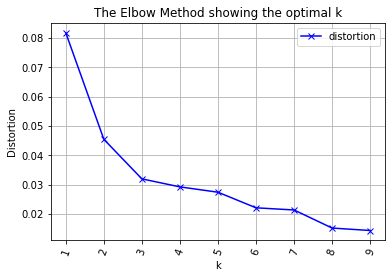

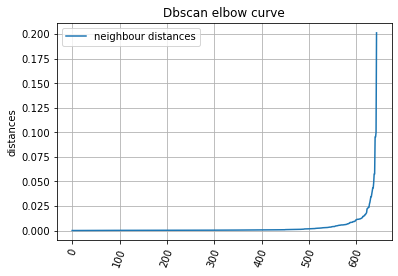

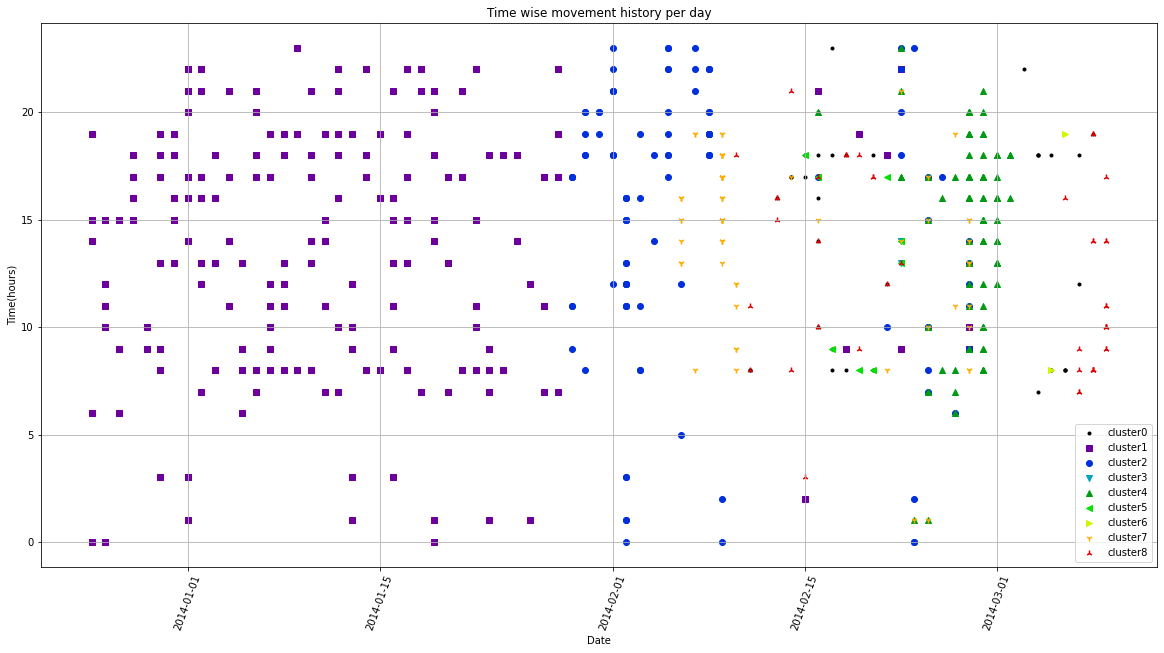

In [52]:
#generating visualizations
visuals = Visualizer(desc.clustered_data, desc.no_clusters)
visuals.plot_kmeans_elbow_curve()
visuals.plot_dbscan_elbow_curve()
visuals.plot_date_time_per_cluster()
visuals.plot_start_time_per_day_per_cluster()
visuals.plot_coordinates_per_day_per_cluster()
#setting parameters for map
latitude = desc.clustered_data['latitude'].mean()#mean of the latitude for the person's movement history
longitude = desc.clustered_data['longitude'].mean() #mean of the longitude for the person's movement history
zoom = 10
visuals.plot_heatmap(latitude, longitude, zoom, desc.clustered_data)
visuals.plot_movement_by_time(latitude, longitude, zoom, desc.clustered_data)
v=visuals.plot_clustered_map(latitude, longitude, zoom, desc.no_clusters, desc.clustered_data)


##### Cluster0: This is probably a secondary home location where the person spends most of the early mornings of weekdays and noon to evenings of some weekends.
##### Cluster1: Interestingly, the entire area around New York city has been categorized as cluster 1. This is most probably a work area, as most of the records are all during day time and spread over weekdays and a few weekends too. This is where DBscan outperforms Kmeans clustering where these weekend points are just noise points and not clustered in any group.
##### Cluster2: This is ambiguous as the idea conveyed is -the person spent most of the weekdays, day through night but also entire weekends. Although there could be a possibility that the person has spent those special weekends working but most probably this is an area where the person has passed while travelling to his destination. Also, we can see, there are a lot of coordinates from this cluster that are disperesed along Hudson river. This can be due to inaccurate GPS coordinates.
##### cluster3: This is straight forward a work location, as most of time spent here is during the day, while one day of a weekend was also spent here. But looking at the times and number of records, this is mostly a work location.
##### cluster4: This is most probably a holiday spot or a visit to friends and relatives because only a weekend was spent here and the number of records are just one. The location, Newburgh is also far away from Nework city
##### cluster5: This is another anomalous clusters where there's just one record during the night on a weekday, and a morning also on a weekday. This is probably an area where the person took while goin to or coming from an actual destination, so it could be a work location.
##### cluster6: This is most probably a work area, as there are more records on weekdays than on weekends. Most of the time spent here is during the noon. The few weekends could be special shifts or simply noise points included in the cluster.
##### cluster7: Similarly, this too is most probably a work area, as there are more records on weekdays than on weekends. Most of the time spent here is during the noon. The few weekends could be special shifts or simply noise points included in the cluster. This cluster has some points which are geographically widely dispersed, these are mostly noise points. So, it is safe to assume, this is yet another work area where the passengers were dropped off in and around Manhattan.
##### cluster8: This too looks like a work area, as most records are from weekdays, noon to night with some special weekends. This could be a few passenger drop offs in Jersey city along with some commute records to or from Newark.

## Deep learning approach of self organizing maps with MiniSom

In [53]:
#building the dataset
d = Dataset(r'person1_NYCtaxi.csv')
cd = ClusteredData()
#Modelling
clustered_data = cd.select_model(d.get_dataframe())
#getting descriptive statistics
desc = DescriptiveStats(clustered_data, 'start_time(YYYYMMddHHmmZ)')
min_start_time = desc.get_min_start_times_per_day_per_cluster()
max_end_time = desc.get_max_end_times_per_day_per_cluster()
mean_time_spent_per_cluster = desc.get_mean_time_spent_per_day_per_cluster()
min_time_spent_per_cluster = desc.get_min_time_spent_per_day_per_cluster()
max_time_spent_per_cluster = desc.get_max_time_spent_per_day_per_cluster()
unique_timezones = desc.get_unique_time_zone_per_cluster()

Available models:
Kmeans
Dbscan
Minisom
Please pick model (0-2): 2
Specify number of rows for map, eg. 4: 4
Specify number of columns for map, eg. 4: 4
Specify number of iterations: 1000


#### generating visualizations

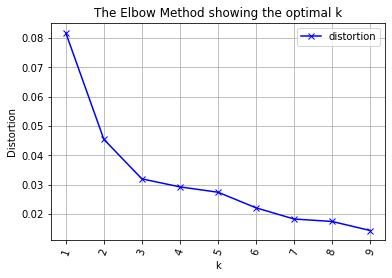

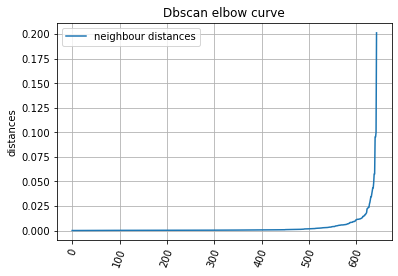

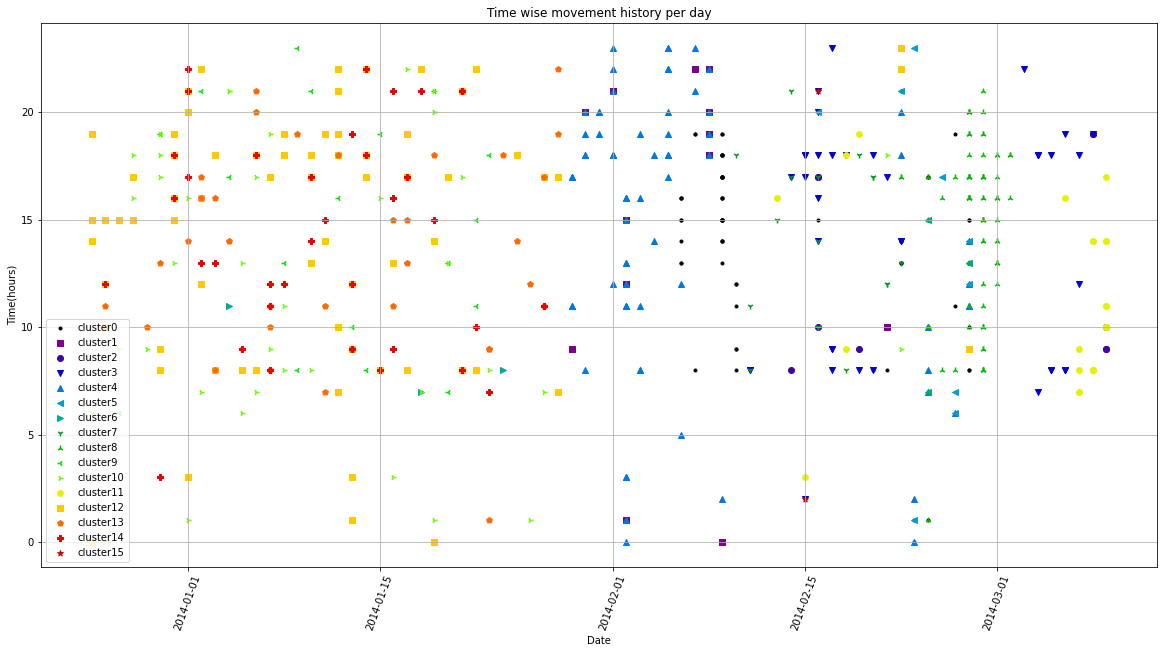

In [54]:
visuals = Visualizer(desc.clustered_data, desc.no_clusters)
visuals.plot_kmeans_elbow_curve()
visuals.plot_dbscan_elbow_curve()
visuals.plot_date_time_per_cluster()
visuals.plot_start_time_per_day_per_cluster()
visuals.plot_coordinates_per_day_per_cluster()
#setting parameters for map
latitude = desc.clustered_data['latitude'].mean()#mean of the latitude for the person's movement history
longitude = desc.clustered_data['longitude'].mean() #mean of the longitude for the person's movement history
zoom = 10
visuals.plot_heatmap(latitude, longitude, zoom, desc.clustered_data)
visuals.plot_movement_by_time(latitude, longitude, zoom, desc.clustered_data)
v=visuals.plot_clustered_map(latitude, longitude, zoom, desc.no_clusters, desc.clustered_data)

#### Evaluation metrics

In [22]:
silhouette_score(desc.clustered_data[['latitude', 'longitude']], desc.clustered_data['cluster_labels'])

0.12937676544235882

In [23]:
print(davies_bouldin_score(desc.clustered_data[['latitude', 'longitude']], desc.clustered_data['cluster_labels'])) 


1.1434032555845133


## Analysis

##### Cluster0: This is an ambiguous cluster more inclined to being a work area. There are more weekday records than weekends, however, the timings are distributed throughout the day. This could be a work location but there can also be a secondary non work location.
##### Cluster1: This looks like a work area as most the weekdays, the person has spent time throughtout the day along with two reocrds on weekends as well. The area is near Manhattan cnetral park, so this could be a possible tourist location.
##### Cluster2: This too looks like a work area as there are too many weekdays records throughout the day with quite a number of weekend records.Also, we can see, there are a lot of coordinates from this cluster that are disperesed along Hudson river. This can be due to inaccurate GPS coordinates.
##### cluster3: This too has many records on weekdays, and some on weekends. The timings are usually regular working hours. The area is some where around Washington Avenue and Knickerbocker Road. So this is most probably a work area
##### cluster4: This too has many records on weekdays, and some on weekends. The timings are usually regular working hours. The area is aroud New York city. So, this is most probably a work area
##### cluster5: This cluster too exhibits similar properties. Many weekday records on usual day working hours and some weekend records. So, this too is most probably a work area.
##### cluster6: This is an ambiguous cluster, as there are almost equal number of weekday and weekend records with usual day hours, but nights and a midnight of weekends. This could be a secondary non work location too where the person drives around for work on weekdays and probably resting or meeting friends and family on weekends. The area is somewhere aroud riverside drive and cliff side park. We can also notice some of the coordinates are inaccurate.
##### cluster7: This cluster exhibits similar properties to cluster 6. The weekend and weekday records are equally balanced. Weekday records are one per day while weekends have multiple. This is a place around New Jersey. this again eithe be a work or non work area.
##### cluster8: This is a straightforward work area. Most of the records are of weekdays and hardly 2 to 3 records on weekends. The number of weekday records are way more than weekend records. The area is also around New York city and is highly likely to be a work area.
##### cluster9: This is a straightforward work area. This cluster is similar to cluster 8 with more number of weekend trips.
##### cluster10: This looks like a random area which is definitely not a regular work or home area as there are hardly 3 records, 2 of whcih are on weekends. This is probably a location that the person commutes through while going to an intended location(proably cluster 5 or 9)
##### cluster11: This is most likely a home location as there are only weekend records and 2 weekday morning records.
##### cluster12: This is most likely a home location as there are only weekend records.
##### cluster13: The timings are mostly during the day till late evenings of weekdays and a number of night to midnight on weekends. Much like cluster 6, this could be an area where the person drives around during for work during weekdays but also visits for some reason on weekends.
##### cluster14: This cluster has mainly weekday records with times from 8 am to 9 pm. There are 2 weekend records as well. This looks most likely to be a work location.
##### cluster15: This cluster has mainly weekday records with times from 8 am to 9 pm. There are 4 weekend records as well. This looks most likely to be a work location.

## Conclusion

#### Density-based methods are best suited for arbitrarily-formed clusters among the various kinds of existing clustering methods. we find that although Lp-norm distances are fast and easy to compute, there are two major problems in utilizing them for density-based clustering of trajectories. First, results achieved from these DFs are highly influenced by the presence of noise and outliers, although L1 is less affected than Euclidean distance. Second, due to not supporting local time shifts, the quality of clustering is deficient from spatio-temporal aspect comparing to the spatial point of view.

#### Although the evaluation metrics suggest Kmeans to be a better clustering option, they are not one size fits all option for unsupervised learning. In unsupervised learning algorithms, there is no ground truth to begin with. The inter and intra cluster metrics can state, how well distinguished a clusgter is but not how valid the clusters are. We should not expect to measure the veracity of our clusters, instead we can focus on the algorithm that can make clusters where the points are most similar as measured by our metric.

#### In our case we see, KMeans does a good job in clustering, which results in distinct clusters but the cluster sizes are big. Our motive is to have smaller clusters so that we can pin point home, work and secondary work and non-work locations. So we can add a heuristic layer and based on the day of the week and time, we can draw conclusions about home and work clusters.